In [1]:
# Imports
from heapq import heappush, heappop
import math
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Graph Class(es)
class Vertex:
    def __init__(self, id, x, y):
        self.id = id
        self.x = x
        self.y = y
        self.edges = {}  # Dictionary of connected vertices and their edges
    
    def __str__(self):
        return f"Vertex {self.id} at ({self.x}, {self.y})"

class Edge:
    def __init__(self, vertex1, vertex2, weights):
        self.vertex1 = vertex1
        self.vertex2 = vertex2
        self.weights = weights
    
    def get_weight(self, traffic_condition='normal'):
        return self.weights.get(traffic_condition, self.weights['normal'])
    
    def __str__(self):
        return f"Edge {self.vertex1.id}-{self.vertex2.id}: {self.weights}"

class Graph:
    def __init__(self):
        self.vertices = {}
        
    def add_vertex(self, id, x, y):
        vertex = Vertex(id, x, y)
        self.vertices[id] = vertex
        return vertex
    
    def add_edge(self, id1, id2, light_traffic, normal_traffic, rush_hour):
        if id1 not in self.vertices or id2 not in self.vertices:
            raise ValueError("Both vertices must exist in the graph")
        
        weights = {
            'light': light_traffic,
            'normal': normal_traffic,
            'rush_hour': rush_hour
        }
        
        edge = Edge(self.vertices[id1], self.vertices[id2], weights)
        self.vertices[id1].edges[id2] = edge
        self.vertices[id2].edges[id1] = edge
        return edge

    def dijkstra(self, start_id, end_id, traffic_condition='normal'):
        """
        Find shortest path between start_id and end_id using Dijkstra's algorithm
        Returns: (total_time, path)
        """
        if start_id not in self.vertices or end_id not in self.vertices:
            raise ValueError("Both start and end vertices must exist in the graph")

        # Initialize distances and predecessors
        distances = {vertex_id: float('infinity') for vertex_id in self.vertices}
        distances[start_id] = 0
        predecessors = {vertex_id: None for vertex_id in self.vertices}
        
        # Priority queue for vertices to visit
        pq = [(0, start_id)]
        visited = set()
        
        while pq:
            current_distance, current_id = heappop(pq)
            
            if current_id == end_id:
                break
                
            if current_id in visited:
                continue
                
            visited.add(current_id)
            
            # Check all neighbors
            for neighbor_id, edge in self.vertices[current_id].edges.items():
                if neighbor_id in visited:
                    continue
                    
                weight = edge.get_weight(traffic_condition)
                distance = current_distance + weight
                
                if distance < distances[neighbor_id]:
                    distances[neighbor_id] = distance
                    predecessors[neighbor_id] = current_id
                    heappush(pq, (distance, neighbor_id))
        
        # Reconstruct path
        path = []
        current_id = end_id
        while current_id is not None:
            path.append(current_id)
            current_id = predecessors[current_id]
        path.reverse()
        
        return distances[end_id], path

    def get_path_description(self, path, traffic_condition='normal'):
        """Generate a description of the path including directions and times"""
        if not path or len(path) < 2:
            return "Invalid path"
            
        description = []
        total_time = 0
        
        for i in range(len(path) - 1):
            current_id = path[i]
            next_id = path[i + 1]
            current_vertex = self.vertices[current_id]
            next_vertex = self.vertices[next_id]
            edge = current_vertex.edges[next_id]
            time = edge.get_weight(traffic_condition)
            total_time += time
            
            # Calculate direction
            dx = next_vertex.x - current_vertex.x
            dy = next_vertex.y - current_vertex.y
            direction = self._get_direction(dx, dy)
            
            description.append(f"From vertex {current_id} go {direction} to vertex {next_id} ({time} minutes)")
        
        description.append(f"\nTotal time: {total_time} minutes")
        return "\n".join(description)

    def _get_direction(self, dx, dy):
        """Helper function to determine cardinal direction"""
        angle = math.degrees(math.atan2(dy, dx))
        if -22.5 <= angle <= 22.5:
            return "east"
        elif 22.5 < angle <= 67.5:
            return "northeast"
        elif 67.5 < angle <= 112.5:
            return "north"
        elif 112.5 < angle <= 157.5:
            return "northwest"
        elif angle > 157.5 or angle <= -157.5:
            return "west"
        elif -157.5 < angle <= -112.5:
            return "southwest"
        elif -112.5 < angle <= -67.5:
            return "south"
        else:
            return "southeast"

In [3]:
# Class for adding/removing police in graph
class PoliceDispatchSystem:
    def __init__(self, graph):
        self.graph = graph
        self.cops = {}  # Dictionary to store cop locations {cop_id: vertex_id}
        
    def add_cop(self, cop_id, vertex_id):
        """Assign a cop to a specific vertex"""
        if vertex_id not in self.graph.vertices:
            raise ValueError("Invalid vertex ID")
        self.cops[cop_id] = vertex_id
        print(f"Cop {cop_id} assigned to location {vertex_id}")
        
    def remove_cop(self, cop_id):
        """Remove a cop from the system"""
        if cop_id in self.cops:
            del self.cops[cop_id]
            print(f"Cop {cop_id} removed from duty")
        else:
            print("Cop ID not found")
            
    def find_nearest_cop(self, crime_location, traffic_condition='normal'):
        """Find the closest cop to the crime scene"""
        if not self.cops:
            return None, None, None
            
        nearest_cop = None
        shortest_time = float('infinity')
        best_path = None
        
        for cop_id, cop_location in self.cops.items():
            time, path = self.graph.dijkstra(cop_location, crime_location, traffic_condition)
            if time < shortest_time:
                shortest_time = time
                nearest_cop = cop_id
                best_path = path
                
        return nearest_cop, shortest_time, best_path

In [4]:
# View graph 
def visualize_graph(graph, path=None, traffic_condition='normal'):
    """
    Visualize the graph using networkx and matplotlib.
    Optional path highlighting for showing routes.
    """
    # Create a NetworkX graph
    G = nx.Graph()
    
    # Add nodes with positions
    pos = {}
    node_colors = []
    for vertex_id, vertex in graph.vertices.items():
        G.add_node(vertex_id)
        pos[vertex_id] = (vertex.x, vertex.y)
        
        # Color nodes based on their type
        if vertex_id <= 5:  # Downtown Core
            node_colors.append('#FF9999')  # Soft red for downtown
        elif vertex_id <= 13:  # Inner Residential 
            node_colors.append('#99FF99')  # Soft green for inner residential
        elif vertex_id <= 21:  # Outer Residential
            node_colors.append('#FFFF99')  # Soft yellow for outer residential
        else:  # Commercial/Industrial
            node_colors.append('#9999FF')  # Soft blue for commercial
    
    # Add edges
    edges = []
    edge_weights = []
    for v_id, vertex in graph.vertices.items():
        for neighbor_id, edge in vertex.edges.items():
            if (neighbor_id, v_id) not in edges:  # Avoid duplicate edges
                edges.append((v_id, neighbor_id))
                edge_weights.append(edge.get_weight(traffic_condition))
    
    G.add_edges_from(edges)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Draw the edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=1)
    
    # If there's a path, highlight it
    if path and len(path) > 1:
        path_edges = list(zip(path[:-1], path[1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, 
                             edge_color='red', width=2)
    
    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=700, alpha=0.8)
    
    # Add node labels
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    # Add edge labels (weights)
    edge_labels = {(u, v): w for (u, v), w in zip(edges, edge_weights)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
    
    # Add legend with enhanced colors
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor='#FF9999', markersize=10, 
                                 label='Downtown Core'),
                      plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor='#99FF99', markersize=10, 
                                 label='Inner Residential'),
                      plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor='#FFFF99', markersize=10, 
                                 label='Outer Residential'),
                      plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor='#9999FF', markersize=10, 
                                 label='Commercial/Industrial')]
    
    if path:
        legend_elements.append(plt.Line2D([0], [0], color='red', 
                                        label='Selected Path'))
    
    plt.legend(handles=legend_elements, loc='upper right')
    
    # Add title with traffic condition
    plt.title(f'Map Visualization ({traffic_condition} traffic)')
    plt.axis('equal')  # Equal aspect ratio
    plt.show()


In [5]:
# Adding verteices menu
def add_vertices_menu(graph):
    """
    Interactive menu system that allows users to add multiple vertices to the graph
    until they choose to stop.
    """
    while True:
        print("\n=== Add New Location to Map ===")
        print("Current vertex IDs in use:", sorted(graph.vertices.keys()))
        
        try:
            # Get vertex details from user
            vertex_id = int(input("\nEnter new vertex ID (integer): "))
            
            # Check if vertex ID already exists
            if vertex_id in graph.vertices:
                print("Error: This vertex ID already exists. Please choose a different ID.")
                continue
                
            x = float(input("Enter x-coordinate: "))
            y = float(input("Enter y-coordinate: "))
            
            # Show available vertices to connect to
            print("\nAvailable vertices to connect to:")
            for v_id, vertex in graph.vertices.items():
                print(f"ID: {v_id} at position ({vertex.x}, {vertex.y})")
            
            connect_to = int(input("\nEnter ID of vertex to connect to: "))
            
            # Validate connection vertex exists
            if connect_to not in graph.vertices:
                print("Error: The vertex you want to connect to doesn't exist.")
                continue
            
            # Get traffic weights
            print("\nEnter traffic weights (typically):")
            print("Minimal traffic: 5-8")
            print("Normal traffic: 8-15")
            print("Heavy traffic: 18-30")
            
            min_weight = float(input("Enter minimal traffic weight: "))
            avg_weight = float(input("Enter normal traffic weight: "))
            max_weight = float(input("Enter heavy traffic weight: "))
            
            # Add the vertex and create connection
            graph.add_vertex(vertex_id, x, y)
            graph.add_edge(vertex_id, connect_to, min_weight, avg_weight, max_weight)
            
            print(f"\nSuccessfully added vertex {vertex_id} and connected it to vertex {connect_to}")
            
            # Ask if user wants to add another vertex
            choice = input("\nWould you like to add another vertex? (y/n): ").lower()
            if choice != 'y':
                print("\nExiting vertex addition menu.")
                break
                
        except ValueError:
            print("Error: Please enter valid numbers for all numerical inputs.")
        except Exception as e:
            print(f"An error occurred: {e}")

Showing basic map:


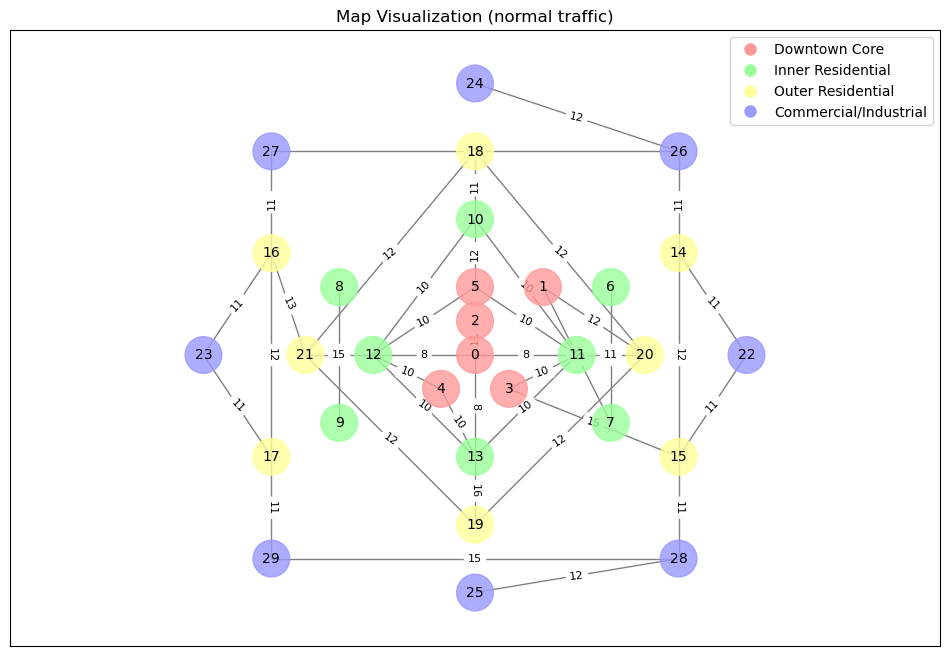

In [6]:
def create_map():
    """Create complex map with additional connections"""
    graph = Graph()
    
    # Add all vertices (same as original)
    # Downtown Core (0-5)
    graph.add_vertex(0, 0, 0)       # Central Plaza
    graph.add_vertex(1, 2, 2)       # Financial District
    graph.add_vertex(2, 0, 1)      # Government Center
    graph.add_vertex(3, 1, -1)      # Shopping District
    graph.add_vertex(4, -1, -1)     # Entertainment District
    graph.add_vertex(5, 0, 2)       # Business Park
    
    # Inner Residential (6-13)
    graph.add_vertex(6, 4, 2)       # North Heights
    graph.add_vertex(7, 4, -2)      # East Gardens
    graph.add_vertex(8, -4, 2)      # West Hills
    graph.add_vertex(9, -4, -2)     # South Vale
    graph.add_vertex(10, 0, 4)      # University District
    graph.add_vertex(11, 3, 0)      # Central Heights
    graph.add_vertex(12, -3, 0)     # Central Valley
    graph.add_vertex(13, 0, -3)     # Lake District
    
    # Outer Residential (14-21)
    graph.add_vertex(14, 6, 3)      # Far North Heights
    graph.add_vertex(15, 6, -3)     # Far East Gardens
    graph.add_vertex(16, -6, 3)     # Far West Hills
    graph.add_vertex(17, -6, -3)    # Far South Vale
    graph.add_vertex(18, 0, 6)      # North End
    graph.add_vertex(19, 0, -5)     # South End
    graph.add_vertex(20, 5, 0)      # East End
    graph.add_vertex(21, -5, 0)     # West End
    
    # Commercial/Industrial Areas (22-29)
    graph.add_vertex(22, 8, 0)      # East Industrial Park
    graph.add_vertex(23, -8, 0)     # West Industrial Park
    graph.add_vertex(24, 0, 8)      # North Mall
    graph.add_vertex(25, 0, -7)     # South Mall
    graph.add_vertex(26, 6, 6)      # Northeast Shopping Center
    graph.add_vertex(27, -6, 6)     # Northwest Shopping Center
    graph.add_vertex(28, 6, -6)     # Southeast Shopping Center
    graph.add_vertex(29, -6, -6)    # Southwest Shopping Center

    # Add all original edges first
    # [All the original edge definitions from create_complex_map()]
    
    # Add new connecting edges to ensure better connectivity
    # Connect Central Plaza to more locations
    graph.add_edge(0, 11, 5, 8, 20)  # Central to Central Heights
    graph.add_edge(0, 12, 5, 8, 20)  # Central to Central Valley
    graph.add_edge(0, 13, 5, 8, 20)  # Central to Lake District

    # Connect Financial District area
    graph.add_edge(1, 7, 6, 10, 22)  # Financial to East Gardens
    graph.add_edge(1, 20, 7, 12, 25) # Financial to East End

    # Connect Shopping District area
    graph.add_edge(3, 11, 6, 10, 22) # Shopping to Central Heights
    graph.add_edge(3, 15, 8, 15, 28) # Shopping to Far East Gardens

    # Connect Entertainment District area
    graph.add_edge(4, 12, 6, 10, 22) # Entertainment to Central Valley
    graph.add_edge(4, 13, 6, 10, 22) # Entertainment to Lake District

    # Connect Business Park area
    graph.add_edge(5, 10, 7, 12, 25) # Business Park to University
    graph.add_edge(5, 11, 6, 10, 22) # Business Park to Central Heights
    graph.add_edge(5, 12, 6, 10, 22) # Business Park to Central Valley

    # Connect Inner Residential areas better
    graph.add_edge(6, 7, 7, 12, 20)  # North Heights to East Gardens
    graph.add_edge(8, 9, 7, 12, 20)  # West Hills to South Vale
    graph.add_edge(10, 11, 6, 10, 18) # University to Central Heights
    graph.add_edge(10, 12, 6, 10, 18) # University to Central Valley
    graph.add_edge(11, 13, 6, 10, 18) # Central Heights to Lake District
    graph.add_edge(12, 13, 6, 10, 18) # Central Valley to Lake District

    # Connect Outer Residential areas better
    graph.add_edge(14, 15, 8, 12, 20) # Far North to Far East
    graph.add_edge(16, 17, 8, 12, 20) # Far West to Far South
    graph.add_edge(18, 20, 8, 12, 20) # North End to East End
    graph.add_edge(18, 21, 8, 12, 20) # North End to West End
    graph.add_edge(19, 20, 8, 12, 20) # South End to East End
    graph.add_edge(19, 21, 8, 12, 20) # South End to West End

    # Connect Shopping Centers to more areas
    graph.add_edge(26, 27, 10, 15, 25) # NE Shopping to NW Shopping
    graph.add_edge(28, 29, 10, 15, 25) # SE Shopping to SW Shopping
    graph.add_edge(26, 24, 8, 12, 22)  # NE Shopping to North Mall
    graph.add_edge(28, 25, 8, 12, 22)  # SE Shopping to South Mall

    # Extra connections
    graph.add_edge(10, 18, 5, 11, 24)
    graph.add_edge(12, 21, 6, 15, 29)
    graph.add_edge(11, 20, 5, 11, 24)
    graph.add_edge(13, 19, 5, 16, 30)
    graph.add_edge(16, 23, 5, 11, 24)
    graph.add_edge(14, 22, 5, 11, 24)
    graph.add_edge(17, 29, 5, 11, 24)
    graph.add_edge(15, 28, 5, 11, 24)
    graph.add_edge(16, 27, 5, 11, 24)
    graph.add_edge(14, 26, 5, 11, 24)
    graph.add_edge(23, 17, 5, 11, 24)
    graph.add_edge(15, 22, 5, 11, 24)
    graph.add_edge(2, 0, 5, 11, 24)
    graph.add_edge(21, 16, 7, 13, 12)

    return graph

graph = create_map()

# Show basic map
print("Showing basic map:")
visualize_graph(graph, traffic_condition='normal')

In [8]:
def main_menu():
    """Main menu interface for the police dispatch system"""
    graph = create_map()
    dispatch_system = PoliceDispatchSystem(graph)
    
    while True:
        print("\n=== Police Dispatch System ===")
        print("1. Display Current Map")
        print("2. Assign Cop to Location")
        print("3. Remove Cop from Duty")
        print("4. Report Crime")
        print("5. Add New Location")
        print("6. List All Cops and Locations")
        print("7. Exit")
        
        try:
            choice = input("\nEnter your choice (1-7): ")

            # Display map
            if choice == '1':
                print("\nDisplaying current map...")
                # Add cop locations to visualization
                visualize_graph(graph, traffic_condition='normal')
                print("Map Legend:")
                print("Red: Downtown Core")
                print("Green: Inner Residential")
                print("Yellow: Outer Residential")
                print("Blue: Commercial/Industrial")
                
            # Assign Cop    
            elif choice == '2':
                cop_id = input("Enter cop ID (e.g., C1, C2): ")
                print("\nAvailable locations:")
                for v_id, vertex in graph.vertices.items():
                    print(f"ID: {v_id} at position ({vertex.x}, {vertex.y})")
                vertex_id = int(input("Enter location ID to assign cop: "))
                dispatch_system.add_cop(cop_id, vertex_id)
                
            # Remove Cop    
            elif choice == '3':
                cop_id = input("Enter cop ID to remove: ")
                dispatch_system.remove_cop(cop_id)
                
            # Report Crime    
            elif choice == '4':
                print("\nAvailable locations:")
                for v_id, vertex in graph.vertices.items():
                    print(f"ID: {v_id} at position ({vertex.x}, {vertex.y})")
                crime_location = int(input("Enter crime location ID: "))
                
                print("\nTraffic conditions:")
                print("1. Light traffic")
                print("2. Normal traffic")
                print("3. Rush hour")
                traffic_choice = input("Select traffic condition (1-3): ")
                
                traffic_map = {'1': 'light', '2': 'normal', '3': 'rush_hour'}
                traffic_condition = traffic_map.get(traffic_choice, 'normal')
                
                nearest_cop, time, path = dispatch_system.find_nearest_cop(crime_location, traffic_condition)
                
                if nearest_cop:
                    print(f"\nDispatch Summary:")
                    print(f"Nearest officer: {nearest_cop}")
                    print(f"Estimated arrival time: {time} minutes")
                    print("\nRoute details:")
                    print(graph.get_path_description(path, traffic_condition))
                    visualize_graph(graph, path, traffic_condition)
                else:
                    print("No officers currently available!")
                    
            # Add new vertex
            elif choice == '5':
                add_vertices_menu(graph)
                
            #  List all Cop locations
            elif choice == '6':
                if dispatch_system.cops:
                    print("\nCurrent Cop Assignments:")
                    for cop_id, location in dispatch_system.cops.items():
                        vertex = graph.vertices[location]
                        print(f"Cop {cop_id} at location {location} ({vertex.x}, {vertex.y})")
                else:
                    print("No cops currently assigned")
                    
            elif choice == '7':
                print("Exiting system...")
                break
                
            else:
                print("Invalid choice. Please try again.")
                
        except ValueError as e:
            print(f"Error: Invalid input - {e}")
        except Exception as e:
            print(f"An error occurred: {e}")

if __name__ == "__main__":
    main_menu()


=== Police Dispatch System ===
1. Display Current Map
2. Assign Cop to Location
3. Remove Cop from Duty
4. Report Crime
5. Add New Location
6. List All Cops and Locations
7. Exit



Enter your choice (1-7):  4



Available locations:
ID: 0 at position (0, 0)
ID: 1 at position (2, 2)
ID: 2 at position (0, 1)
ID: 3 at position (1, -1)
ID: 4 at position (-1, -1)
ID: 5 at position (0, 2)
ID: 6 at position (4, 2)
ID: 7 at position (4, -2)
ID: 8 at position (-4, 2)
ID: 9 at position (-4, -2)
ID: 10 at position (0, 4)
ID: 11 at position (3, 0)
ID: 12 at position (-3, 0)
ID: 13 at position (0, -3)
ID: 14 at position (6, 3)
ID: 15 at position (6, -3)
ID: 16 at position (-6, 3)
ID: 17 at position (-6, -3)
ID: 18 at position (0, 6)
ID: 19 at position (0, -5)
ID: 20 at position (5, 0)
ID: 21 at position (-5, 0)
ID: 22 at position (8, 0)
ID: 23 at position (-8, 0)
ID: 24 at position (0, 8)
ID: 25 at position (0, -7)
ID: 26 at position (6, 6)
ID: 27 at position (-6, 6)
ID: 28 at position (6, -6)
ID: 29 at position (-6, -6)


Enter crime location ID:  0



Traffic conditions:
1. Light traffic
2. Normal traffic
3. Rush hour


Select traffic condition (1-3):  1


No officers currently available!

=== Police Dispatch System ===
1. Display Current Map
2. Assign Cop to Location
3. Remove Cop from Duty
4. Report Crime
5. Add New Location
6. List All Cops and Locations
7. Exit


KeyboardInterrupt: Interrupted by user

In [ ]:
# import networkx as nx
import matplotlib.pyplot as plt

class Vertex:
    def __init__(self, id, x, y):
        self.id = id
        self.x = x
        self.y = y
        self.edges = {}  # Dictionary of connected vertices and their edges
    
    def __str__(self):
        return f"Vertex {self.id} at ({self.x}, {self.y})"

class Edge:
    def __init__(self, vertex1, vertex2, weight):
        self.vertex1 = vertex1
        self.vertex2 = vertex2
        self.weight = weight

# Function to create a graph
def create_graph(vertices, edges):
    graph = nx.Graph()
    for vertex in vertices:
        graph.add_node(vertex.id, pos=(vertex.x, vertex.y))
    for edge in edges:
        graph.add_edge(edge.vertex1.id, edge.vertex2.id, weight=edge.weight)
    return graph

# Function to find the shortest path using Dijkstra's algorithm
def find_shortest_path(graph, start_id, end_id):
    return nx.dijkstra_path(graph, start_id, end_id, weight='weight')

# Function to visualize a graph
def visualize_graph(graph, title):
    pos = nx.get_node_attributes(graph, 'pos')
    labels = nx.get_edge_attributes(graph, 'weight')
    plt.figure(figsize=(8, 6))
    nx.draw(graph, pos, with_labels=True, node_size=700, node_color="lightblue")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    plt.title(title)
    plt.show()

# Example vertices and edges for both graphs
crime_vertices = [Vertex(1, 0, 0), Vertex(2, 1, 2), Vertex(3, 4, 1)]
crime_edges = [Edge(crime_vertices[0], crime_vertices[1], 2.5), 
               Edge(crime_vertices[1], crime_vertices[2], 1.5),
               Edge(crime_vertices[0], crime_vertices[2], 4.0)]

cops_vertices = [Vertex(1, 0, 0), Vertex(2, 2, 2), Vertex(3, 5, 1), Vertex(4, 1, 5)]
cops_edges = [Edge(cops_vertices[0], cops_vertices[1], 2.0), 
              Edge(cops_vertices[1], cops_vertices[2], 3.0),
              Edge(cops_vertices[1], cops_vertices[3], 2.5),
              Edge(cops_vertices[0], cops_vertices[3], 5.0)]

# Create graphs for crimes and cops
crime_graph = create_graph(crime_vertices, crime_edges)
cops_graph = create_graph(cops_vertices, cops_edges)

# Find the shortest path in the cops graph
start_node = 1
end_node = 3
shortest_path = find_shortest_path(cops_graph, start_node, end_node)

# Visualize both graphs and print the shortest path
visualize_graph(crime_graph, "Crime Graph")
visualize_graph(cops_graph, "Cops Graph")
print(f"Shortest path in the cops graph from {start_node} to {end_node}: {shortest_path}")

In [ ]:
# Initial crime graph setup
crime_vertices = [Vertex(1, 0, 0), Vertex(2, 2, 2)]
crime_edges = [Edge(crime_vertices[0], crime_vertices[1], 3)]

# Create the initial crime graph
crime_graph = create_graph(crime_vertices, crime_edges)
visualize_graph(crime_graph, "Initial Crime Graph")

# Allow user to input new crime location
new_crime_id = len(crime_vertices) + 1
print("Enter the coordinates of the new crime location (x, y):")
new_x, new_y = map(float, input("Coordinates: ").split(','))
new_crime_vertex = Vertex(new_crime_id, new_x, new_y)

# Connect the new crime location to an existing one
connect_to = int(input(f"Connect the new crime location (ID {new_crime_id}) to an existing node (ID options: {[v.id for v in crime_vertices]}): "))
connect_weight = float(input(f"Enter the weight (distance) to connect node {new_crime_id} to node {connect_to}: "))
new_crime_edge = Edge(new_crime_vertex, crime_vertices[connect_to - 1], connect_weight)

# Update the crime graph
crime_vertices.append(new_crime_vertex)
crime_edges.append(new_crime_edge)
crime_graph = create_graph(crime_vertices, crime_edges)

# Visualize the updated crime graph
visualize_graph(crime_graph, "Updated Crime Graph")

# This code allows dynamic addition of new crime locations and connections based on user input.
# It visualizes both the initial and updated crime graph.